In [21]:
import os
import xarray as xr
import pymc as pymc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import arviz as az
from scipy.special import expit

<h1>Helper functions</h1>

<h3>1. Convert SFI data to pandas format</h3>

In [22]:
import pandas as pd
import numpy as np

def sfi_file_to_pandas(filename):
    with open(filename, 'r') as f:
        inlines = f.readlines()

    outstruct = {}
    sitelist = []

    for line in inlines:
        if "year_start" in line:
            outstruct['year_start'] = int(line.split("=")[1].strip())
        elif "year_end" in line:
            outstruct['year_end'] = int(line.split("=")[1].strip())
        elif "[" in line:
            sitename = line.split("[")[1].split("]")[0]
            sitelist.append(sitename)

    nlines = len(inlines)
    ln = 0

    while ln < nlines:
        for sitename in sitelist:
            if sitename in inlines[ln]:
                nrules = int(inlines[ln + 1].split("=")[1])
                rules = {}
                for rule in range(nrules):
                    key, values = inlines[ln + 2 + rule].split("=")
                    rules[key.strip()] = [float(val) for val in values.strip().split(",")]
                outstruct[sitename] = rules
                ln += nrules + 2
                break
        else:
            ln += 1

    timeindex = pd.date_range(
        start=f"{outstruct['year_start']}-07-01",
        end=f"{outstruct['year_end']}-06-30",
        freq="YE-JUN"
    )

    dfs = [pd.DataFrame(outstruct[site], index=timeindex) for site in sitelist]
    outdf = pd.concat(dfs, axis=1, join='inner')

    return outdf


<h3>2. Calculate annual inflow from daily</h3>

In [23]:
def calculate_annual_inflow(inflow_file):
    """
    Reads inflow data from a CSV file, processes it, and calculates annual 
    inflow totals based on a June-ending year.
    
    Parameters:
        inflow_file (str): Path to the CSV file containing inflow data. 
                           The file must have a 'date' column.

    Returns:
        pd.DataFrame: Annual inflow totals with a June-ending year.
    """
    # Read inflow data and parse dates
    inflow_data = pd.read_csv(inflow_file, parse_dates=['date'])
    
    # Set the 'date' column as the index
    inflow_data.set_index('date', inplace=True)
    
    # Resample data to calculate annual totals for a June-ending year
    annual_inflow = inflow_data.resample("YE-JUN").sum()
    
    return annual_inflow

<h3>3. Get scenarios</h3>

In [24]:
all_indicators = {}

all_indicators["BMF"] = ["BMF_R1", "BMF_R2", "BMF_R3", "BMF_R4", "BMF_R5", "BMF_R6", "BMF_R7"]
all_indicators["CHO"] = ["CHO_R1", "CHO_R2", "CHO_R3", "CHO_R4", "CHO_R5", "CHO_R6", "CHO_R7"]

def get_indicators(location):
    return all_indicators[location]
    

<h3>4. Global variables</h3>

In [25]:
ewater_values = [0,2750]

<h1>Load data</h1>

In [26]:
# Set the directory where various input files are located
data_dir = "/datasets/lw-hydrofct/work/common/Staff/sch537/specific_flow_indicators/data/"

<h3>1. Achievement data</h3>
Load in success for all locations</br>
*B0H000* is the baseline diversion limit scenario and *P0H000* is the fully implemented plan scenario </br>
We therefore set ewater to 0.0 or 2750.0 accordingly.<br>

In [27]:
input_file_b = os.path.join(data_dir, "_MURR_B0H000__eFA_annual_stats_10discount.txt")
predictands_b = (sfi_file_to_pandas(input_file_b)).assign(ewater=0.0)
predictands_b["year_idx"] = np.arange(len(predictands_b))

input_file_p = os.path.join(data_dir, "_MURR_P0H000__eFA_annual_stats_10discount.txt")
predictands_p = (sfi_file_to_pandas(input_file_p)).assign(ewater=2750.0)
predictands_p["year_idx"] = np.arange(len(predictands_p))

predictands = pd.concat([predictands_b, predictands_p])
predictands.columns

Index(['BMF_R1', 'BMF_R2', 'BMF_R3', 'BMF_R4', 'BMF_R5', 'BMF_R6', 'BMF_R7',
       'GKP_R1', 'GKP_R2', 'GKP_R3', 'GKP_R4', 'GKP_R5', 'HAT_R1', 'HAT_R2',
       'HAT_R3', 'HAT_R4', 'HAT_R5', 'HAT_R6', 'CHO_R1', 'CHO_R2', 'CHO_R3',
       'CHO_R4', 'CHO_R5', 'CHO_R6', 'CHO_R7', 'EDW_R1', 'EDW_R2', 'EDW_R3',
       'EDW_R4', 'EDW_R5', 'LDF_R1', 'LDF_R2', 'LDF_R3', 'LDF_R4', 'LDF_R5',
       'ewater', 'year_idx'],
      dtype='object')

<h3>2. Inflow data</h3>
The "B" and "P" inflows are slightly different which we assume are caused by MDBA tweaks the model. We adopt
the "P" inflows for both ewater scenarios<br>
Despite the above, it is best practice to ensure that "B" and "P" files are read in the same order as the predictand data so the rows line up.

In [28]:
flow_var_to_use="local"

input_file_b = os.path.join(data_dir, "MURR_B0H.csv")
annual_predictor_b = calculate_annual_inflow(input_file_b)
annual_predictor_b["year_idx"] = np.arange(len(annual_predictor_b))

input_file_p = os.path.join(data_dir, "MURR_P0H.csv")
annual_predictor_p = calculate_annual_inflow(input_file_p)
annual_predictor_p["year_idx"] = np.arange(len(annual_predictor_p))

## NB: We are choosing one model to represent the inflows, hence using annual_predictor_p twice
annual_predictor_b["inflow"] = annual_predictor_p[flow_var_to_use]

# Data are concatenated so we have rows
annual_predictor = pd.concat([annual_predictor_b, annual_predictor_p])
annual_predictor["inflow"] = annual_predictor[flow_var_to_use]

# total inflow into the system
# outflow - flow out of the catchment 
# local - inflow from local catchment area

<h3>3. Calculate lagged inflow</h3>

In [29]:
annual_predictor["lagged_inflow"] = annual_predictor["inflow"].shift(1)

<h3>4. Join predictor and predictand data</h3>

In [30]:
data = predictands.copy()
for column in annual_predictor.columns:
    data[column] = annual_predictor[column]

# remove the first year (1896) since it is NaN for lagged case
# Use drop since the same date occurs multiple times in the data table
data = data.drop(datetime.datetime(1896,6,30))
# need to adjust year index accordingly to have 0-index
data["year_idx"] = data["year_idx"]-1

<h2>4. Combined model with shared slopes and lagged predictor</h2>

In [112]:
location = "CHO"

<h3>4.1 Define model</h3>

In [113]:
def shared_effects_lagged_model(predictor1, predictor2, predictor3, predictor4, predictand):
    
    with pymc.Model() as model:

        n = len(np.unique(predictor3))
        
        beta0 = pymc.Normal("beta0", mu=0, sigma=5, shape=n)
        beta1 = pymc.Normal("beta1", mu=0, sigma=5)
        beta2 = pymc.Normal("beta2", mu=0, sigma=5)
        beta3 = pymc.Normal("beta3", mu=0, sigma=5)
        
        x1 = pymc.Data("x1", predictor1)
        x2 = pymc.Data("x2", predictor2)
        x3 = pymc.Data("x3", predictor3)
        idx = pymc.Data("idx", predictor4)

        mu = beta0[idx] + beta1 * x1 + beta2 * x2 + beta3 * x3

        p = pymc.Deterministic("p", pmath.invlogit(mu))

        y = pymc.Bernoulli("y", p=p, observed=predictand)
    
    return model

<h3>4.2 Fit model</h3>

In [114]:
import pymc
import pymc.math as pmath
import numpy as np
import pandas as pd
import arviz as az

indicators = get_indicators(location)

sel_data = pd.melt(
    data,
    id_vars=['inflow', 'lagged_inflow', 'ewater', 'year_idx'],
    value_vars=indicators,
    var_name='indicator',
    value_name='target'
)

# Encode the indicator (optional: strip the "BMF_R" prefix if you want integers)
sel_data['indicator_idx'] = sel_data['indicator'].str.extract(r'R(\d)').astype(int) - 1  # 0-based indexing

traces_combined_shared_effects_lagged = {}
data_combined_shared_effects_lagged = {}
    
predictor1 = np.log(sel_data["inflow"])
p1_mean = predictor1.mean()
p1_std = predictor1.std()
predictor1 = (predictor1 - p1_mean)/p1_std


predictor2 = sel_data["ewater"]
predictor2 = (predictor2 / sel_data["ewater"].max()) - 0.5

predictor3 = np.log(sel_data["lagged_inflow"])
p3_mean = predictor3.mean()
p3_std = predictor3.std()
predictor3 = (predictor3 - p3_mean)/p3_std

predictor4 = sel_data["indicator_idx"]

predictand = sel_data["target"]
        
model = shared_effects_lagged_model(predictor1, predictor2, predictor3, predictor4, predictand)
    
# Perform MCMC sampling
trace = pymc.sample(
    draws=2000,
    tune=4000,
    chains=4,
    target_accept=0.85,
    model=model
)
   
traces_combined_shared_effects_lagged[f"{location}"] = trace
    
ptor_ptand_data = pd.DataFrame(predictor1)
ptor_ptand_data = ptor_ptand_data.rename({"inflow":"predictor1"}, axis=1)
ptor_ptand_data["ewater"] = predictor2
ptor_ptand_data["predictor3"] = predictor3
ptor_ptand_data["indicator_idx"] = predictor4
ptor_ptand_data["predictand"] = predictand
        
data_combined_shared_effects_lagged[f"{location}"] = ptor_ptand_data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 58 seconds.


In [115]:
data["inflow"]

1897-06-30    4.225391e+06
1898-06-30    4.986283e+06
1899-06-30    6.189946e+06
1900-06-30    5.112734e+06
1901-06-30    5.576845e+06
                  ...     
2005-06-30    5.462452e+06
2006-06-30    6.492137e+06
2007-06-30    2.152755e+06
2008-06-30    2.827960e+06
2009-06-30    2.667191e+06
Name: inflow, Length: 226, dtype: float64

In [116]:
test_years = np.arange(2013,2025)
test_inflow = np.array([8865754.8, 5860827.6, 4236603, 3579682.4,15964194.8,4061445.4,2892890.2,\
               4650394.4,6172049.3,16227654.3,30579425.6,16227654.3])
lagged_inflow = np.array([15969078.5, 8865754.8, 5860827.6, 4236603, 3579682.4,15964194.8,4061445.4,2892890.2,\
               4650394.4,6172049.3,16227654.3,30579425.6])
test_ewater = np.array([1294.50,1552.10,1709.50,1806.60,1890.9,2015.9,2093.4,2108.3,2107.7,2109.4,\
               2119.6,2157.7])

test_inflow = np.log(test_inflow)
test_inflow = (test_inflow-p1_mean)/p1_std

lagged_inflow = np.log(lagged_inflow)
lagged_inflow = (lagged_inflow-p3_mean)/p3_std
test_ewater = (test_ewater/2750)-0.5



In [117]:
indicator_idx = []
for yr_i, yr in enumerate(test_years):
    print(yr, test_inflow[yr_i], lagged_inflow[yr_i], test_ewater[yr_i])
    indicator_idx.append(np.arange(0,7))

indicator_idx = np.array(indicator_idx)
print(indicator_idx)

2013 0.6885413332863636 2.0788080177312303 -0.029272727272727284
2014 -0.2711671039545509 0.6865796397774895 0.06440000000000001
2015 -1.02364189156015 -0.2926754132723293 0.12163636363636365
2016 -1.4143087225523485 -1.060476038401561 0.1569454545454545
2017 2.0522706505452013 -1.4590996760220727 0.1876
2018 -1.1215426151774666 2.078084364647031 0.23305454545454551
2019 -1.9082265397718097 -1.1603707299342403 0.2612363636363637
2020 -0.8075647064247874 -1.9630772378886865 0.2666545454545455
2021 -0.15119904484986346 -0.8399979565365073 0.2664363636363636
2022 2.090223641078334 -0.17026393544830576 0.26705454545454543
2023 3.5593555335180036 2.1168103529948783 0.2707636363636363
2024 2.090223641078334 3.615864413001069 0.28461818181818177
[[0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]]


Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []


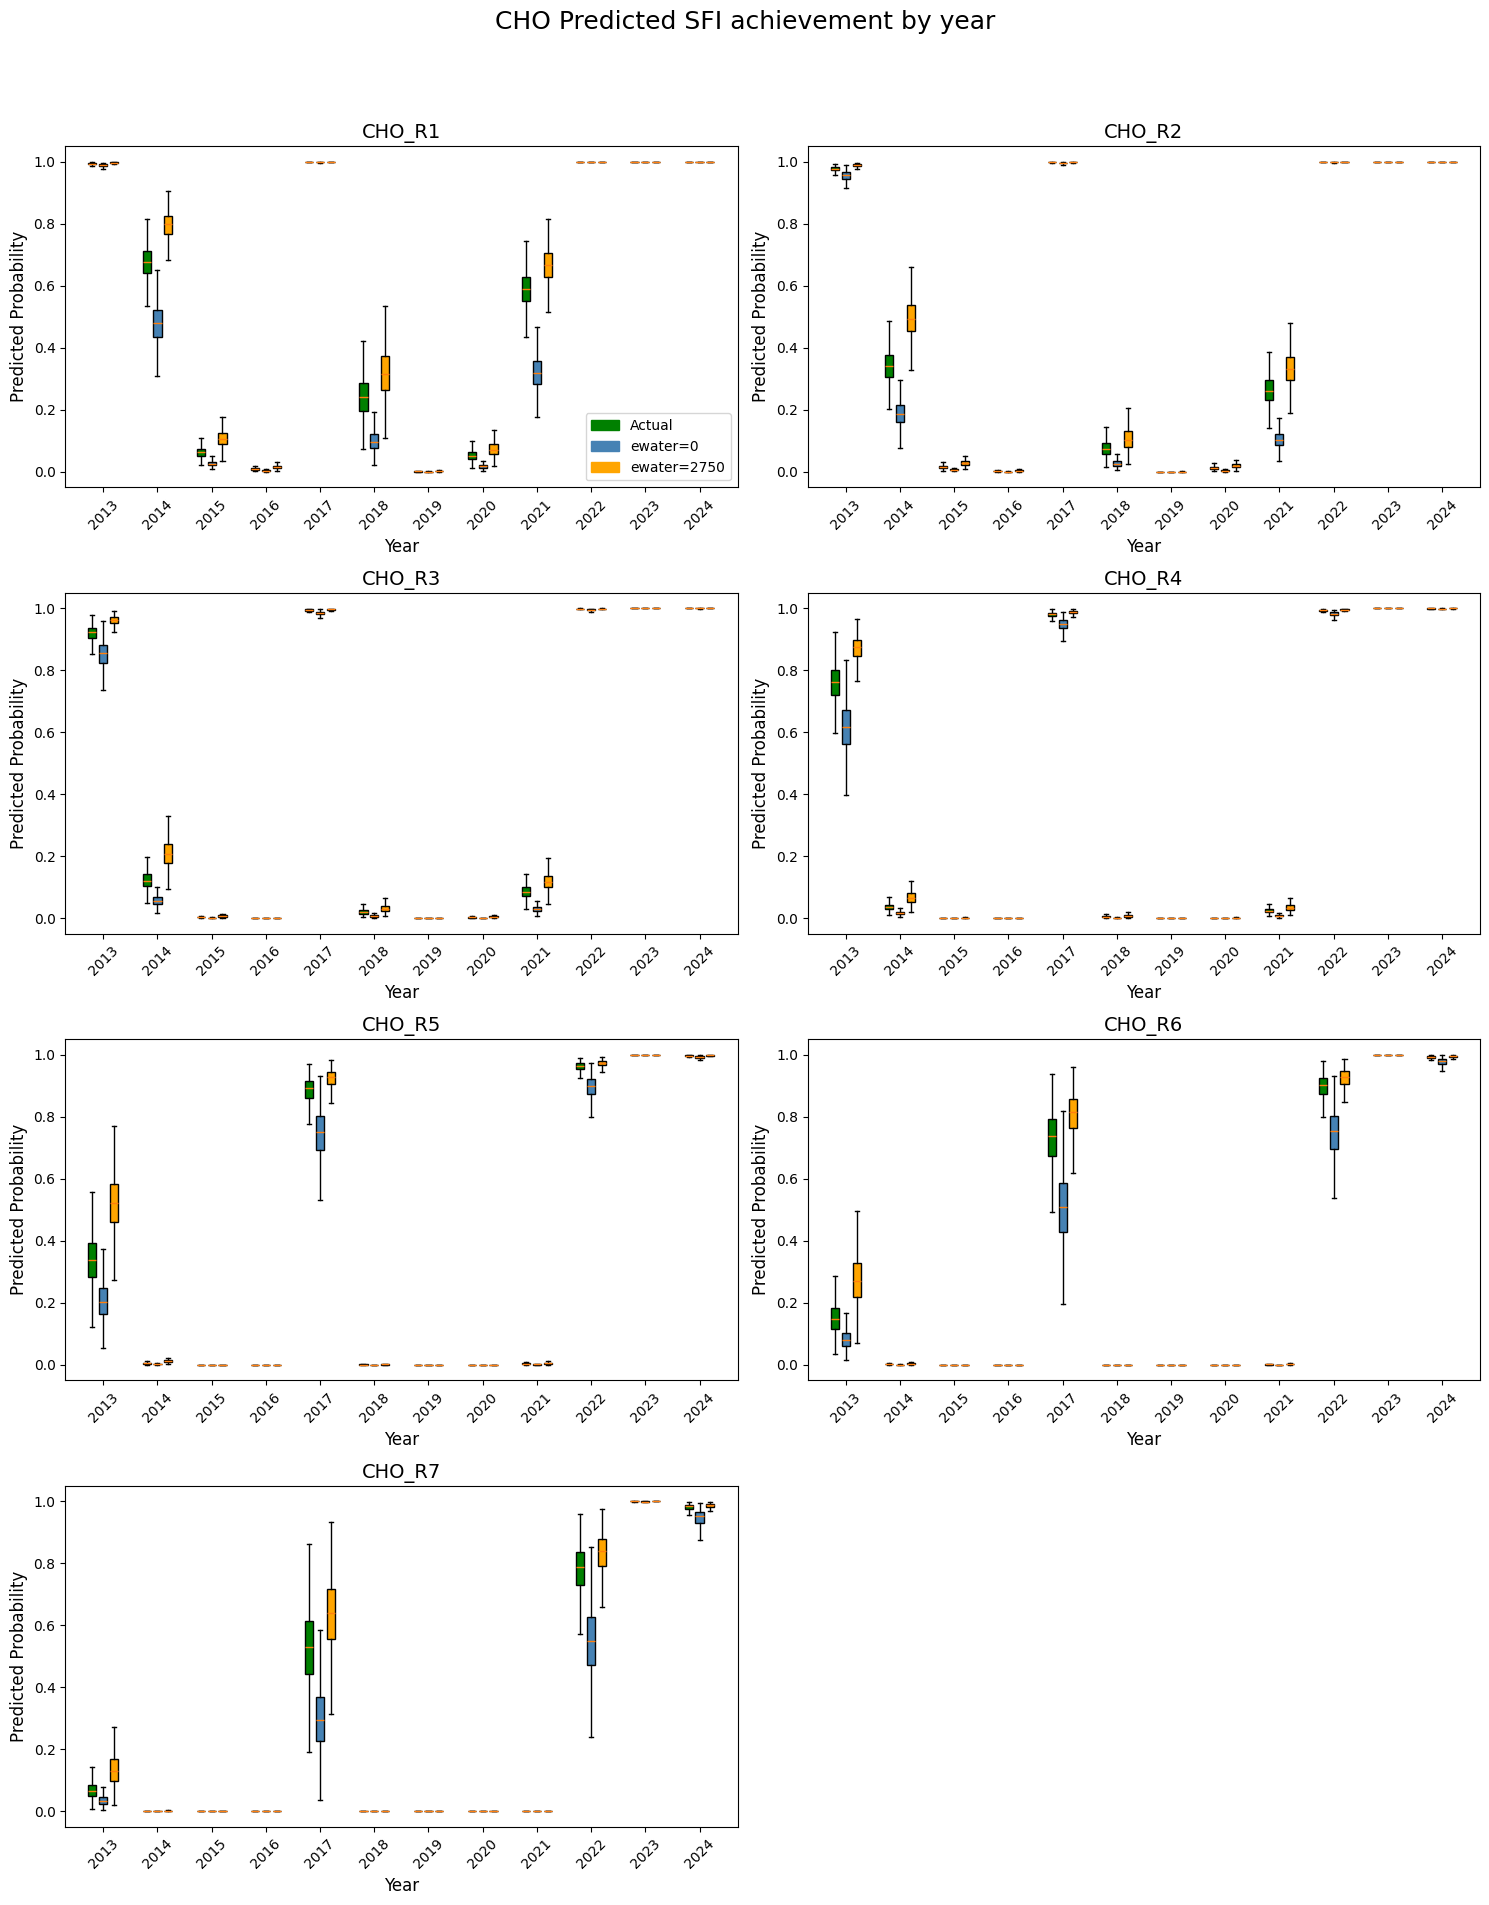

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pymc as pm  # Assuming PyMC3 or PyMC4

indicators = get_indicators(location)
years = np.arange(2013, 2025)  # Assuming years from 2013 to 2024
n_years = len(years)
x2_cases = [("Actual", test_ewater), ("ewater=0", [-0.5]*n_years), ("ewater=2750", [0.5]*n_years)]  # Labels & x2 values
colors = ["green", "steelblue", "orange"]  # Colors for each case

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))  # Adjust grid size if needed
axes = axes.flatten()

offsets = [-0.2, 0, 0.2]  # Small shifts for boxplots

for indicator_i, indicator in enumerate(indicators):
    
    ax = axes[indicator_i]  # Get the subplot for this indicator

    for case_i, (label, x2_value) in enumerate(x2_cases):

        test_idx = np.array([indicator_i] * len(test_years))
        
        with model:
            pm.set_data({
                "x1": test_inflow,
                "x2": x2_value,
                "x3": lagged_inflow,
                "idx": test_idx
            })

            posterior_pred = pm.sample_posterior_predictive(trace, var_names=["p"], progressbar=False, predictions=True)
            posterior_predictive_samples = posterior_pred.predictions["p"].values  # No transpose needed
            posterior_predictive_samples = posterior_predictive_samples.reshape(-1, posterior_predictive_samples.shape[2])
            
        # Offset each boxplot slightly to avoid overlap
        ax.boxplot(posterior_predictive_samples, positions=np.arange(n_years) + offsets[case_i], 
                   widths=0.15, patch_artist=True, showfliers=False,
                   boxprops=dict(facecolor=colors[case_i]))

    ax.set_xticks(np.arange(n_years))
    ax.set_xticklabels(years, rotation=45, fontsize=10)
    ax.set_title(f"{indicator}", fontsize=14)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Predicted Probability", fontsize=12)
    ax.set_ylim(-0.05, 1.05)  # Ensure probabilities are correctly scaled
    
    # Add legend only to the first panel
    if indicator_i == 0:
        legend_handles = [mpatches.Patch(color=colors[i], label=x2_cases[i][0]) for i in range(3)]
        ax.legend(handles=legend_handles, loc="best", fontsize=10)

# Hide unused subplots if there are fewer than 8 indicators
for j in range(len(indicators), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(f"{location} Predicted SFI achievement by year", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

